<h4>Thesis</h4>
<h6>These models try predict if the score of the home team(principal) is larger than the visitor team, utilizing KNN. <br>The variables X are: "home_odds", "draw_odds", "away_odds"<br>
The variables Y are: "win_home"</h6>

<h6>win (BACK) = win of home team</h6>

<h6>When the quantity of the score of the visitor team is larger than the home team(principal) then assign 1 to the field "win_home". When the quantity of the score of the visitor team is minus than of the home team(principal) then assign 0 to field "win_home".</h6>

<h6>*The secret to increase the hit rate is to choose good variables. The better the variables the higher the hit rate will be.*</h6>

<h5>Import dataset</h5>
<h6>*The secret to increase the hit rate is to choose good variables. The better the variables the higher the hit rate will be.*</h6>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings

pd.set_option("display.min_rows", 200)
pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 100)

# Premier League - England
premier_league_2016_2017 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1617/E0.csv")
premier_league_2017_2018 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1718/E0.csv")
premier_league_2018_2019 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1819/E0.csv")
premier_league_2019_2020 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1920/E0.csv")
premier_league_2020_2021 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2021/E0.csv")
premier_league_2021_2022 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv")
premier_league_2022_2023 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/E0.csv")

df = pd.concat([premier_league_2016_2017, premier_league_2017_2018, premier_league_2018_2019, premier_league_2019_2020, premier_league_2020_2021, premier_league_2021_2022, premier_league_2022_2023], axis=0, ignore_index=True)
#df = pd.concat([premier_league_2021_2022, premier_league_2022_2023], axis=0, ignore_index=True)
df["League"] = "Premier League"
df = df[["League", "Date", "HomeTeam", "AwayTeam", "HTHG", "HTAG", "HTR", "FTHG", "FTAG", "FTR", "B365H", "B365D", "B365A"]]
df.columns = ["league", "date", "home", "away", "home_goals_ht", "away_goals_ht", "result_ht", "home_goals_ft", "away_goals_ft", "result_ft", "home_odds", "draw_odds", "away_odds"]
df = df.astype({"date":"datetime64"})
df = df.convert_dtypes(infer_objects=True)
df.reset_index(inplace=True, drop=True)
df.tail()

,league,date,home,away,home_goals_ht,away_goals_ht,result_ht,home_goals_ft,away_goals_ft,result_ft,home_odds,draw_odds,away_odds
2496,Premier League,2023-11-02,Bournemouth,Newcastle,1,1,D,1,1,D,6.50,4.00,1.53
2497,Premier League,2023-12-02,Leeds,Man United,0,0,D,0,2,A,3.75,3.80,1.91
2498,Premier League,2023-12-02,Man City,Aston Villa,3,0,H,3,1,H,1.25,6.50,11.00
2499,Premier League,2023-02-13,Liverpool,Everton,1,0,H,2,0,H,1.50,4.33,6.50
2500,Premier League,2023-02-15,Arsenal,Man City,1,1,D,1,3,A,2.90,3.50,2.35


<h5>Feature Engineering and Preprocessing</h5>
<h6>When the quantity of the score of the home team(principal) is larger than the visitor team then assign 1 to the field "win_home".When the quantity of the score of the visitor team is minus than of the home team(principal) then assign 0 to field "win_home".</h6>

In [13]:
df["result_ht"] = LabelEncoder().fit_transform(df["result_ht"]) 
df["result_ft"] = LabelEncoder().fit_transform(df["result_ft"])
df["sum_odds"] = df["home_odds"] + df["away_odds"] + df["draw_odds"]
df["mandrake"] = np.mean(df["sum_odds"]) / (df["home_odds"] + df["draw_odds"] + df["away_odds"])
df.loc[(df["home_goals_ft"] > df["away_goals_ft"]), "win_home"] = 1
df.loc[(df["home_goals_ft"] <= df["away_goals_ft"]), "win_home"] = 0
df.tail()

,league,date,home,away,home_goals_ht,away_goals_ht,result_ht,home_goals_ft,away_goals_ft,result_ft,home_odds,draw_odds,away_odds,sum_odds,mandrake,win_home,predictions,probability_0,probability_1,profit,profit_accumulated
2489,Premier League,2023-08-02,Man United,Leeds,0,1,0,2,2,1,1.45,5.00,6.0,12.45,1.135055,0.0,1.0,0.33,0.67,-1.00,496.74
2491,Premier League,2023-11-02,Arsenal,Brentford,0,0,1,1,1,1,1.44,4.75,7.0,13.19,1.071375,0.0,1.0,0.00,1.00,-1.00,495.74
2494,Premier League,2023-11-02,Leicester,Tottenham,3,1,2,4,1,2,3.40,3.60,2.1,9.10,1.552905,1.0,1.0,0.33,0.67,2.40,498.14
2498,Premier League,2023-12-02,Man City,Aston Villa,3,0,2,3,1,2,1.25,6.50,11.0,18.75,0.753677,1.0,1.0,0.00,1.00,0.25,498.39
2499,Premier League,2023-02-13,Liverpool,Everton,1,0,2,2,0,2,1.50,4.33,6.5,12.33,1.146102,1.0,1.0,0.00,1.00,0.50,498.89


<h5>Defining X and Y</h5>

In [3]:
X = df.loc[:, ["home_odds", "draw_odds", "away_odds", "sum_odds", "mandrake"]]
y = df.loc[:, "win_home"]

<h5>Pre processing (Standard Scaler)</h5>

In [ ]:
std = StandardScaler()
X = std.fit_transform(X)

<h5>Split Train and Test</h5>

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X)

(1875, 5) (626, 5) (1875,) (626,)
[[-0.26989548 -0.66167931 -0.36322255 -0.5973683   0.84022532]
 [-0.43406624 -0.66167931 -0.09426329 -0.4458392   0.43994396]
 [ 0.05844604 -0.59585615 -0.54611485 -0.58845483  0.81458638]
 ...
 [-0.74188641  1.44466167  1.3043249   1.14967312 -1.57188586]
 [-0.63927968  0.01629919  0.33607154  0.00518272 -0.42487843]
 [-0.06468203 -0.530033   -0.55687322 -0.63302221  0.94571123]]


<h5>Train the Model</h5>

In [5]:
knn = KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
knn.fit(X_train, y_train)

KNeighborsClassifier()

<h5>Evaluate the Model</h5>

In [6]:
y_predictions = knn.predict(X_test)

print(f"Accuracy score (training): {knn.score(X_train, y_train)}")
print(f"Accuracy score (validation): {knn.score(X_test, y_test)}\n")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_predictions)}\n")
print(f"Classification Report:\n {classification_report(y_test, y_predictions)}")

Accuracy score (training): 0.7301333333333333
Accuracy score (validation): 0.6837060702875399

Confusion Matrix:
 [[256  90]
 [108 172]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.74      0.72       346
         1.0       0.66      0.61      0.63       280

    accuracy                           0.68       626
   macro avg       0.68      0.68      0.68       626
weighted avg       0.68      0.68      0.68       626



<h5>Informations about model</h5>

In [7]:
print(f"Games that was predicted as been 0 and was 0: {confusion_matrix(y_test, y_predictions)[0][0]}")
print(f"Games that was predicted as been 0 and was 1: {confusion_matrix(y_test, y_predictions)[1][0]}")
print(f"Games that was predicted as been 1 and was 0: {confusion_matrix(y_test, y_predictions)[0][1]}")
print(f"Games that was predicted as been 1 and was 1: {confusion_matrix(y_test, y_predictions)[1][1]}")

test_total_matches = confusion_matrix(y_test, y_predictions)[0][0] + \
                     confusion_matrix(y_test, y_predictions)[0][1] + \
                     confusion_matrix(y_test, y_predictions)[1][0] + \
                     confusion_matrix(y_test, y_predictions)[1][1]

entry_games = confusion_matrix(y_test, y_predictions)[0][1] + confusion_matrix(y_test, y_predictions)[1][1]
entry_tax = (entry_games / test_total_matches) * 100
hit_rate = (confusion_matrix(y_test, y_predictions)[1][1] / entry_games) * 100

print(f"Total Matches: {test_total_matches}")
print(f"Entry Games: {entry_games}")
print(f"Entry Tax: {entry_tax.round(2)}%")
print(f"Hit Rate: {hit_rate.round(2)}%")

Games that was predicted as been 0 and was 0: 256
Games that was predicted as been 0 and was 1: 108
Games that was predicted as been 1 and was 0: 90
Games that was predicted as been 1 and was 1: 172
Entry Games: 262
Entry Tax: 41.85%
Hit Rate: 65.65%


<h5>Prevision / Probabilities of classification</h5>

In [8]:
knn = KNeighborsClassifier(n_neighbors=3, metric="minkowski", p=2)
knn.fit(X, y)
predict_probability = knn.predict_proba(X)
df["predictions"] = y_predictions = knn.predict(X)
df["probability_0"] = predict_probability[:, 0].round(2)
df["probability_1"] = predict_probability[:, 1].round(2)
df.tail()

,league,date,home,away,home_goals_ht,away_goals_ht,result_ht,home_goals_ft,away_goals_ft,result_ft,home_odds,draw_odds,away_odds,sum_odds,mandrake,win_home,predictions,probability_0,probability_1
2496,Premier League,2023-11-02,Bournemouth,Newcastle,1,1,1,1,1,1,6.50,4.00,1.53,12.03,1.022521,0.0,0.0,1.00,0.00
2497,Premier League,2023-12-02,Leeds,Man United,0,0,1,0,2,0,3.75,3.80,1.91,9.46,1.300309,0.0,0.0,0.67,0.33
2498,Premier League,2023-12-02,Man City,Aston Villa,3,0,2,3,1,2,1.25,6.50,11.00,18.75,0.656049,1.0,1.0,0.00,1.00
2499,Premier League,2023-02-13,Liverpool,Everton,1,0,2,2,0,2,1.50,4.33,6.50,12.33,0.997642,1.0,1.0,0.00,1.00
2500,Premier League,2023-02-15,Arsenal,Man City,1,1,1,1,3,0,2.90,3.50,2.35,8.75,1.405820,0.0,0.0,1.00,0.00


<h5>Backtest</h5>

In [9]:
stake = 1
win_back = stake * (df["home_odds"] - 1)
lose_back = -stake

df.loc[(df["predictions"] == 1) & (df["win_home"] == 1), "profit"] = win_back
df.loc[(df["predictions"] == 1) & (df["win_home"] == 0), "profit"] = lose_back
df.loc[(df["predictions"] == 0) & (df["win_home"] == 1), "profit"] = 0
df.loc[(df["predictions"] == 0) & (df["win_home"] == 1), "profit"] = 0

df = df[df["predictions"] == 1]
df["profit_accumulated"] = df["profit"].cumsum()
df.tail(20)

,league,date,home,away,home_goals_ht,away_goals_ht,result_ht,home_goals_ft,away_goals_ft,result_ft,home_odds,draw_odds,away_odds,sum_odds,mandrake,win_home,predictions,probability_0,probability_1,profit,profit_accumulated
2446,Premier League,2023-02-01,Brentford,Liverpool,2,0,2,3,1,2,5.50,4.33,1.55,11.38,1.080925,1.0,1.0,0.33,0.67,4.50,485.60
2450,Premier League,2023-03-01,Man United,Bournemouth,1,0,2,3,0,2,1.29,5.50,11.00,17.79,0.691452,1.0,1.0,0.00,1.00,0.29,485.89
2459,Premier League,2023-01-14,Brighton,Liverpool,0,0,1,3,0,2,3.40,3.60,2.10,9.10,1.351750,1.0,1.0,0.33,0.67,2.40,488.29
2462,Premier League,2023-01-14,Wolves,West Ham,0,0,1,1,0,2,2.63,3.30,2.70,8.63,1.425368,1.0,1.0,0.33,0.67,1.63,489.92
2463,Premier League,2023-01-14,Brentford,Bournemouth,1,0,2,2,0,2,1.65,4.00,5.25,10.90,1.128525,1.0,1.0,0.33,0.67,0.65,490.57
2464,Premier League,2023-01-15,Chelsea,Crystal Palace,0,0,1,1,0,2,1.62,4.00,5.25,10.87,1.131640,1.0,1.0,0.33,0.67,0.62,491.19
2465,Premier League,2023-01-15,Newcastle,Fulham,0,0,1,1,0,2,1.50,4.33,6.50,12.33,0.997642,1.0,1.0,0.00,1.00,0.50,491.69
2468,Premier League,2023-01-19,Man City,Tottenham,0,2,0,4,2,2,1.36,5.00,8.50,14.86,0.827788,1.0,1.0,0.33,0.67,0.36,492.05
2476,Premier League,2023-01-22,Man City,Wolves,1,0,2,3,0,2,1.20,8.00,11.00,20.20,0.608957,1.0,1.0,0.00,1.00,0.20,492.25
2477,Premier League,2023-01-22,Arsenal,Man United,1,1,1,3,2,2,1.80,3.80,4.20,9.80,1.255197,1.0,1.0,0.33,0.67,0.80,493.05


<h5>Plot Backtest</h5>

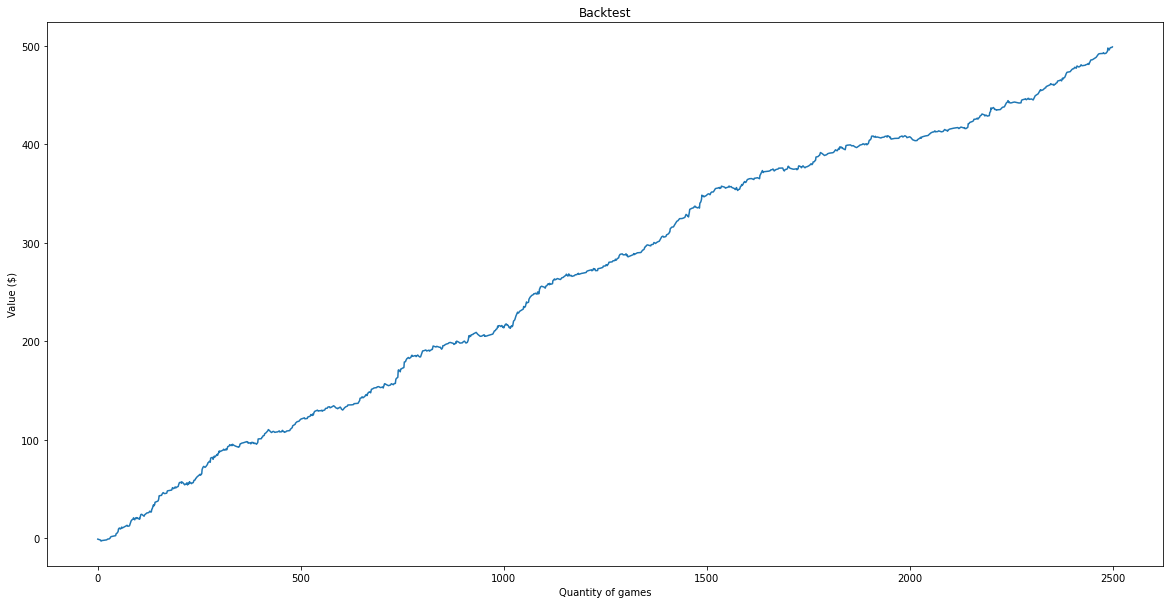

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(df["profit_accumulated"])
plt.xlabel("Quantity of games")
plt.ylabel("Value ($)")
plt.title("Backtest")
plt.show()

<h5>ROI (Return on Investment)</h5>

In [11]:
roi = (df["profit_accumulated"].tail(1)/ len(df)) * 100
print(f"ROI: {roi.values}")

ROI: [46.58169935]


<h5>Choosing the specific match</h5>

In [12]:
'''
home_odds = input("Input Home Odd: ")
draw_odds = input("Input Draw Odd: ")
away_odds = input("Input Away Odd: ")
'''

home_odds = 3.88
draw_odds = 1.80
away_odds = 2.30
sum_odds = home_odds + draw_odds + away_odds

odds = [float(home_odds), float(away_odds), float(draw_odds), float(sum_odds)]
odds_match = np.array(odds)

forecast_match = odds_match.reshape(1, -1)
forecast_match = knn.predict(forecast_match)

if forecast_match == 1:
    print("Home")
elif forecast_match == 0:
    print("Stay out of this game.")


ValueError: X has 4 features, but KNeighborsClassifier is expecting 5 features as input.